In [1]:
from pandas import DataFrame, read_csv, concat
from numpy import matrix, bincount
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid')

In [2]:
class Dataset:
  def __init__(self, dataset_url, label='Outcome'):
    self.dataset = read_csv(dataset_url)
    self.label = self.dataset[label]
    self.data = self.dataset.drop(label, axis=1)
    self.std_dev = self.data.std().values
    self.mean = self.data.mean().values

  def standard_scaler(self, x, x_mean, x_std_dev):
    return (x - x_mean) / x_std_dev

  def preprocess(self):
    pp_data = []
    for row in self.data.values:
      pp_row = list(map(self.standard_scaler, row, self.mean, self.std_dev))
      pp_data.append(pp_row)
    pp_data = matrix(pp_data)
    return pp_data

  def split_data(self, *split_range):
    pp_data = DataFrame(self.preprocess())
    test_data, train_data = [], []
    for sr in split_range:
      if len(sr) == 2:
        r1, r2 = sr
        x_train = pp_data[r1-1:r2]
        y_train = self.label[r1-1:r2]
      else:
        r1, r2, r3 = sr
        x_train = concat([pp_data[:r1], pp_data[r2-1:r3]])
        y_train = concat([self.label[:r1], self.label[r2-1:r3]])
      x_test = pp_data.drop(x_train.index).values
      y_test = self.label.drop(y_train.index).values
      x_train = x_train.values
      y_train = y_train.values
      test = list(zip(x_test, y_test))
      train = list(zip(x_train, y_train))
      test_data.append(test)
      train_data.append(train)
    return test_data, train_data


In [3]:
class KNearestNeighbor:
  def square_difference(self, x1_p, x2_p):
    return (x1_p - x2_p) ** 2

  def euclidean_distance(self, x1, x2):
    distance = map(self.square_difference, x1, x2)
    distance = sum(distance) ** 0.5
    return distance

  def classification(self, k, test, train):
    x_test, y_test = test
    label = []
    for x_train, y_train in train:
      distance = self.euclidean_distance(x_test, x_train)
      label.append((distance, y_train))
    label = sorted(label, key=lambda lbl: lbl[0])[:k]
    label = [y for distance, y in label]
    label = bincount(label).argmax()
    return label

  def train(self, k, test, train):
    label_train = []
    for ts in test:
      label = self.classification(k, ts, train)
      label_train.append(label)
    return label_train

  def accuracy_score(self, k, test, train):
    label_train = self.train(k, test, train)
    label_test = [y for x, y in test]
    data_size = len(label_train)
    score = sum([1/data_size
                 for tr, ts in zip(label_train, label_test)
                 if tr == ts])
    return score

  def cross_validation(self, max_k, test, train):
    score_list = []
    k_list = [k for k in range(1, max_k+1, 2)]
    for k in k_list:
      current_score = []
      for ts, tr in zip(test, train):
        score = self.accuracy_score(k, ts, tr)
        current_score.append(score)
      current_score = sum(current_score) / len(current_score) * 100
      score_list.append(current_score)
    idx_best = score_list.index(max(score_list))
    score_best = score_list[idx_best]
    k_best = 2 * idx_best + 1
    return score_best, k_best, k_list, score_list

  def estimate(self, k_best, dataset):
    data = DataFrame(dataset.preprocess()).values
    label = dataset.label.values
    data = list(zip(data, label))
    size = len(data)
    score_final = 0
    for i in range(size):
      test = [data[i]]
      train = [xy for j, xy in enumerate(data) if j != i]
      score_final += self.accuracy_score(k_best, test, train) / size * 100
    return score_final

In [4]:
data_range = [(1, 614), (461, 615, 768), (307, 462, 768), 
              (154, 308, 768), (155, 768)]
csv_domain = 'https://docs.google.com/spreadsheets/d'
csv_id = '1LYy6IKpI8CaaHAALDeu52N2xUg6Qo4cZvAxMaSOQOG0'
csv_export = 'export?format=csv'
dataset_url = f'{csv_domain}/{csv_id}/{csv_export}'
ds = Dataset(dataset_url)
test, train = ds.split_data(*data_range)

In [5]:
knn = KNearestNeighbor()
score_best, k_best, k_list, score_list = knn.cross_validation(50, test, train)
score_final = knn.estimate(k_best, ds)

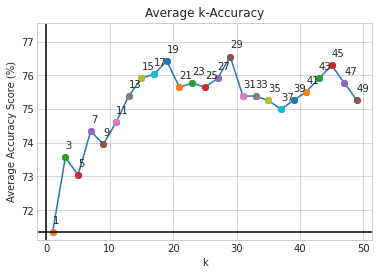

In [6]:
plt.title('Average k-Accuracy')
plt.xlabel('k')
plt.ylabel('Average Accuracy Score (%)')
plt.plot(k_list, score_list, '-o')
for k, score in zip(k_list, score_list):
  plt.plot(k, score, 'o')
  plt.text(k, score + .25, k)
plt.ylim((min(score_list) - .25, score_best + 1))
plt.axhline(min(score_list), color='k')
plt.axvline(color='k')
plt.savefig('k-vs-score.png')
plt.show()

In [7]:
k_output = 'Best k: {}'.format(k_best)
score_train_output = 'Final 5-fold cross validation accuracy score: {:.2f}%'.format(score_best)
score_test_output = 'Final all data accuracy score: {:.2f}%'.format(score_final)
print(f'{k_output}\n{score_train_output}\n{score_test_output}')

Best k: 29
Final 5-fold cross validation accuracy score: 76.56%
Final all data accuracy score: 74.61%
